# Basic Portfolio Analysis

## 0. Data

Utilize the readily available Yahoo Finance data

In [3]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from datetime import datetime


In [23]:
# We choose a few stocks with long history
tickers = ['JPM','DIS','SHEL']
startdate = datetime(1995,1,1)

close_px = pdr.get_data_yahoo(tickers, start=startdate)['Adj Close']
# fill na with previous close 
close_px.fillna(method = 'backfill', inplace=True)
close_px.head(3)

[*********************100%***********************]  3 of 3 completed


,DIS,JPM,SHEL
Date,,,
1995-01-03,11.607052,5.434782,7.622498
1995-01-04,11.513696,5.528482,7.622498
1995-01-05,11.482578,5.584704,7.587251


In [82]:
returns = close_px.pct_change()
returns.dropna(inplace = True)
returns.head(3)

,DIS,JPM,SHEL
Date,,,
1995-01-04,-0.008043,0.017241,0.000000
1995-01-05,-0.002703,0.010169,-0.004624
1995-01-06,-0.002710,0.003356,-0.001152


## 1. Returns & Risks
### Returns:

In [83]:
# Calculate the cumulative return, expressed in %
((returns+1).prod()-1)*100

DIS      666.516790
JPM     2412.704223
SHEL     634.404906
dtype: float64

<AxesSubplot:xlabel='Date'>

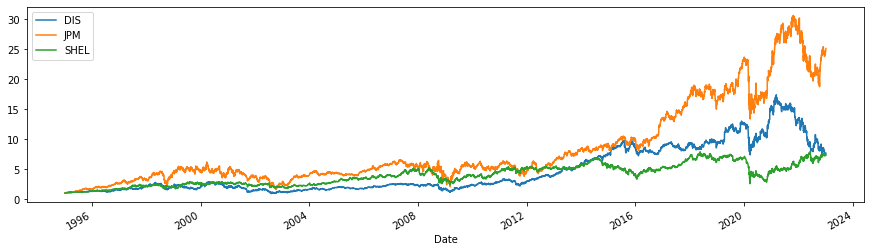

In [84]:
# Evolution of returns
(returns+1).cumprod().plot.line(figsize = (15, 4))

In [85]:
# Annualized return for this period 
((((returns+1).prod())**(1/len(returns)))**(260)-1)*100

DIS      7.799322
JPM     12.623520
SHEL     7.629342
dtype: float64

### Risk measures:
1. Standard Deviation
2. Max drawdown
3. Semi deviation

In [86]:
# Calculate the annualized St Dev, expressed in %
returns.std()*(260**0.5)*100

DIS     31.195834
JPM     38.297557
SHEL    29.382922
dtype: float64

In [87]:
# Calculate Max drawdown
cum_returns = (returns+1).cumprod()
prev_peaks = (returns+1).cumprod().cummax()
drawdowns = (cum_returns - prev_peaks) / prev_peaks
maxdrawdown = drawdowns.min()
maxdrawdown

DIS    -0.678808
JPM    -0.740207
SHEL   -0.672374
dtype: float64

In [88]:
maxdrawdown_date = drawdowns.idxmin()
maxdrawdown_date

DIS    2002-08-13
JPM    2002-10-09
SHEL   2020-03-18
dtype: datetime64[ns]

In [89]:
# Calculate semi deviation, i.e. the negative deviation 
returns[returns<0].std()*(260**0.5)*100

DIS     22.002794
JPM     27.219214
SHEL    21.949387
dtype: float64

### Risk adjusted return: Sharpe ratio

In [90]:
# Asssume risk free rate of 3%, calculate the annulized Sharpe for the period
rf = 0.03
ann_ret = ((((returns+1).prod())**(1/len(returns)))**(260)-1)*100
ann_std = returns.std()*(260**0.5)*100

sharpe = (ann_ret - rf*100)/ann_std
sharpe

DIS     0.153845
JPM     0.251283
SHEL    0.157552
dtype: float64

### Value at Risk
1. Historical VaR
2. Gaussian VaR
3. Semi parametric Cornish-Fisher VaR

In [111]:
# Calculate historical daily VaR at 95% confidence
-np.percentile(returns, (1-0.95)*100,  axis = 0)

array([0.02838529, 0.03339026, 0.02616216])

In [112]:
# Calculate Gaussian VaR
import scipy.stats as stats

In [113]:
zscore = stats.norm.ppf(1-0.95)
GVaR = -(returns.mean() + zscore*returns.std())
GVaR

DIS     0.031347
JPM     0.038330
SHEL    0.029524
dtype: float64

In [114]:
# Calculate Cornish-Fisher VaR

skewness = (((returns - returns.mean())**3).mean())/(returns.std()**3)
kurtosis = (((returns - returns.mean())**4).mean())/(returns.std()**4)
z =  (zscore +
        (zscore**2 - 1)*skewness/6 +
        (zscore**3 -3*zscore)*(kurtosis-3)/24 -
        (2*zscore**3 - 5*zscore)*(skewness**2)/36
      )

CFVaR = -(returns.mean() + z*returns.std())
CFVaR

DIS     0.026625
JPM     0.026572
SHEL    0.025604
dtype: float64